# Super-Resolution Model Training

## Environment Setup

The following cell verifies GPU availability in the execution environment.

In [1]:
import sys
import torch

print(sys.executable)
print(torch.__file__)
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())


/home/bhtran/repo/Super-Resolution/.venv/bin/python
/home/bhtran/repo/Super-Resolution/.venv/lib/python3.12/site-packages/torch/__init__.py
2.9.1+cu126
12.6
True


In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm.auto import tqdm

### Data loading
We will create a custom dataset class for loading our images. This class will inherit from `torch.utils.data.Dataset` and implement the necessary methods to load and preprocess the images (and maybe data augmentation in the future).

In [3]:
class SuperResolutionDataset(Dataset):
    def __init__(self, npz_file_path):
        """Load tensors from .npz file"""
        data = np.load(npz_file_path)
        self.hr_images = data['hr']
        self.lr_images = data['lr']

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        #Because the image dimension is (batch, height, width, channels) 
        #So i do a permutation here to (C,H,W) to fit the model
        lr = torch.from_numpy(self.lr_images[idx]).permute(2, 0, 1)
        hr = torch.from_numpy(self.hr_images[idx]).permute(2, 0, 1)

        return lr, hr

training_dataset = SuperResolutionDataset('../data/hr_lr_images.npz')
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)

### Data Split
Split the dataset into training and validation sets to evaluate model performance during training.

In [4]:
from torch.utils.data import random_split

# Split dataset into training (80%), validation (15%), and test (5%)
train_size = int(0.8 * len(training_dataset))
val_size = int(0.15 * len(training_dataset))
test_size = len(training_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(training_dataset, [train_size, val_size, test_size])

# Create dataloaders for training, validation, and test
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

Training samples: 13883
Validation samples: 2603
Test samples: 868


In [14]:
import sys
sys.path.insert(0, '..')
from src.model2 import ResidualSuperResolutionModel

## Model Instantiation

The following cell serves as a sanity check to ensure the model functions as expected. This is particularly important in notebook environments where previous execution states may persist.

In [15]:
model = ResidualSuperResolutionModel()
x = torch.randn(1, 3, 32, 32)
y = model(x)
print(type(y))
print(y.shape)

<class 'torch.Tensor'>
torch.Size([1, 3, 128, 128])


## Model Architecture Validation

The model should not exceed 5 million trainable parameters to ensure computational efficiency.

In [16]:
# device refers to the GPU or the CPU, depending whether GPU is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = ResidualSuperResolutionModel().to(device)

# display information about the model
summary(model, (3,32,32))

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable parameters:', params)
if params > 5_000_000:
    raise Exception('Your model is unecessarily complex, scale down!')

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
            Conv2d-2           [-1, 64, 32, 32]          36,928
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
     ResidualBlock-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,928
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
     ResidualBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,928
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,928
    ResidualBlock-13           [-1, 64, 32, 32]               0
           Conv2d-14

## Loss Functions and Optimization

### Training Configuration and Hyperparameter Setup

In [17]:
# Custom callback for plotting loss and accuracy during training
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import clear_output


class PlotLogAccuracy:

  def __init__(self):
    self.epochs = []
    self.train_losses = []
    self.val_losses = []
    self.train_acc = []
    self.val_acc = []
    self.epoch_count = 0

  def update(self, train_loss, train_acc, val_loss, val_acc):
    self.epochs.append(self.epoch_count)
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_count += 1

    clear_output(wait=True)
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(self.epochs, self.train_losses, label="train loss")
    plt.plot(self.epochs, self.val_losses, label="validation loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Model Loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(self.epochs, self.train_acc, label="training accuracy")
    plt.plot(self.epochs, self.val_acc, label="validation accuracy")
    plt.legend()
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Model Accuracy')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show();

plotter = PlotLogAccuracy()

In [24]:
epochs = 100
batch_size = 64
learning_rate = 0.005
momentum = 0.9

criterion = nn.MSELoss()

# setting the model (calling this again will reset the weights)
model = ResidualSuperResolutionModel().to(device)

# play with this
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-4)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=0, pin_memory=torch.cuda.is_available())
valloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=0, pin_memory=torch.cuda.is_available())
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=0, pin_memory=torch.cuda.is_available())

train_loss_hist, val_loss_hist = [], []

print('Setup complete.')

Setup complete.


### Peak Signal-to-Noise Ratio (PSNR) Validation Metric

The Peak Signal-to-Noise Ratio (PSNR) is employed as the primary image quality metric for validation.

In [19]:
def psnr(pred, target):
    mse = torch.mean((pred - target) ** 2)
    return 10 * torch.log10(1.0 / (mse + 1e-8))

### Perceptual Loss Function

Given that high-resolution images in this dataset are limited to 128×128 pixels, the PSNR metric reaches a theoretical maximum of approximately 23 dB. To address this limitation, perceptual loss is introduced as a complementary metric. Perceptual loss evaluates image similarity based on high-level feature representations extracted from pre-trained neural networks, rather than pixel-level differences.

In [22]:
from torchvision.models import vgg16
import torch.nn.functional as F

class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(pretrained=True).features[:16]
        for p in vgg.parameters():
            p.requires_grad = False
        self.vgg = vgg.eval()

    def forward(self, x, y):
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1,3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1,3,1,1)

        x = (x - mean) / std
        y = (y - mean) / std

        fx = self.vgg(x)
        fy = self.vgg(y)

        return F.l1_loss(fx, fy)
l1_loss = nn.L1Loss()
perc_loss = VGGPerceptualLoss().to(device)
lambda_perc = 0.01


In [ ]:
print('Starting training...')

# Epoch Loop: It iterates through the specified number of training epochs.

for epoch in range(epochs):

    # For each epoch, all data in the dataset is processed.

    model.train() # Sets the model to training mode

    running_loss = 0.0 # resetting loss metric

    #  Iterates through the `trainloader` to get mini-batches of data
    for x_batch, y_batch in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False):

        # copying data to the GPU (the `device`) if GPU is available
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()           # setting up gradient to zero
        out = model(x_batch)            # Performs the forward pass

        # loss = criterion(out, y_batch)  # calculates the loss

        loss_l1 = l1_loss(out, y_batch)
        loss_perc = perc_loss(out, y_batch)
        loss = loss_l1 + lambda_perc * loss_perc

        loss.backward()                 # performs backpropagation in parallel on the batch
        optimizer.step()                # optimizer steps to update the model's weights

        # updating current training loss on the mini-batch
        running_loss += loss.item() * x_batch.size(0)

    train_loss = running_loss / len(trainloader.dataset)

    # Computing Validation Loss

    model.eval() # switching model to eval mode, disabling dropout/batchnorm/other custom modules
    val_running_loss = 0.0
    val_psnr = 0.0
    with torch.no_grad(): # we disable gradient computation to save some memory
        for x_batch, y_batch in tqdm(valloader, desc=f'Epoch {epoch+1}/{epochs} [Val]', leave=False):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            out = model(x_batch)
            loss = l1_loss(out, y_batch)
            val_running_loss += loss.item() * x_batch.size(0)
            val_psnr += psnr(out, y_batch).item()
    val_loss = val_running_loss / len(valloader.dataset)
    val_psnr /= len(valloader)

    # scheduler.step()

    # Record training loss
    train_loss_hist.append(train_loss); val_loss_hist.append(val_loss)

    # Print loss for training/validation
    print(
        f'Epoch {epoch+1}: '
        f'Train Loss {train_loss:.4f} | '
        f'Val Loss {val_loss:.4f} | '
        f'Val PSNR {val_psnr:.2f} dB'
    )

print('Training finished.')


Starting training...


Epoch 1/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1: Train Loss 0.1728 | Val Loss 0.0933 | Val PSNR 15.86 dB


Epoch 2/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 2: Train Loss 0.0923 | Val Loss 0.0699 | Val PSNR 18.36 dB


Epoch 3/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 3: Train Loss 0.0792 | Val Loss 0.0632 | Val PSNR 18.94 dB


Epoch 4/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 4/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 4: Train Loss 0.0738 | Val Loss 0.0596 | Val PSNR 19.24 dB


Epoch 5/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 5/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 5: Train Loss 0.0710 | Val Loss 0.0578 | Val PSNR 19.39 dB


Epoch 6/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 6: Train Loss 0.0695 | Val Loss 0.0566 | Val PSNR 19.47 dB


Epoch 7/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 7: Train Loss 0.0685 | Val Loss 0.0558 | Val PSNR 19.53 dB


Epoch 8/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 8/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 8: Train Loss 0.0677 | Val Loss 0.0551 | Val PSNR 19.58 dB


Epoch 9/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 9/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 9: Train Loss 0.0671 | Val Loss 0.0546 | Val PSNR 19.62 dB


Epoch 10/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 10/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 10: Train Loss 0.0666 | Val Loss 0.0542 | Val PSNR 19.65 dB


Epoch 11/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 11/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 11: Train Loss 0.0661 | Val Loss 0.0538 | Val PSNR 19.68 dB


Epoch 12/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 12/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 12: Train Loss 0.0657 | Val Loss 0.0534 | Val PSNR 19.73 dB


Epoch 13/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 13/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 13: Train Loss 0.0595 | Val Loss 0.0449 | Val PSNR 22.91 dB


Epoch 14/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 14/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 14: Train Loss 0.0546 | Val Loss 0.0442 | Val PSNR 23.03 dB


Epoch 15/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 15/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 15: Train Loss 0.0539 | Val Loss 0.0439 | Val PSNR 23.09 dB


Epoch 16/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 16/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 16: Train Loss 0.0535 | Val Loss 0.0436 | Val PSNR 23.13 dB


Epoch 17/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 17/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 17: Train Loss 0.0531 | Val Loss 0.0433 | Val PSNR 23.17 dB


Epoch 18/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 18/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 18: Train Loss 0.0528 | Val Loss 0.0431 | Val PSNR 23.20 dB


Epoch 19/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 19/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 19: Train Loss 0.0526 | Val Loss 0.0429 | Val PSNR 23.24 dB


Epoch 20/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 20/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 20: Train Loss 0.0523 | Val Loss 0.0428 | Val PSNR 23.26 dB


Epoch 21/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 21/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 21: Train Loss 0.0521 | Val Loss 0.0426 | Val PSNR 23.29 dB


Epoch 22/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 22/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 22: Train Loss 0.0519 | Val Loss 0.0424 | Val PSNR 23.31 dB


Epoch 23/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 23/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 23: Train Loss 0.0517 | Val Loss 0.0423 | Val PSNR 23.33 dB


Epoch 24/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 24/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 24: Train Loss 0.0516 | Val Loss 0.0422 | Val PSNR 23.35 dB


Epoch 25/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 25/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 25: Train Loss 0.0514 | Val Loss 0.0420 | Val PSNR 23.37 dB


Epoch 26/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 26/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 26: Train Loss 0.0513 | Val Loss 0.0419 | Val PSNR 23.39 dB


Epoch 27/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 27/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 27: Train Loss 0.0511 | Val Loss 0.0419 | Val PSNR 23.41 dB


Epoch 28/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 28/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 28: Train Loss 0.0510 | Val Loss 0.0417 | Val PSNR 23.42 dB


Epoch 29/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 29/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 29: Train Loss 0.0509 | Val Loss 0.0416 | Val PSNR 23.44 dB


Epoch 30/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 30/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 30: Train Loss 0.0507 | Val Loss 0.0416 | Val PSNR 23.45 dB


Epoch 31/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 31/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 31: Train Loss 0.0506 | Val Loss 0.0415 | Val PSNR 23.46 dB


Epoch 32/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 32/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 32: Train Loss 0.0505 | Val Loss 0.0414 | Val PSNR 23.47 dB


Epoch 33/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 33/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 33: Train Loss 0.0504 | Val Loss 0.0413 | Val PSNR 23.48 dB


Epoch 34/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 34/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 34: Train Loss 0.0504 | Val Loss 0.0413 | Val PSNR 23.49 dB


Epoch 35/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 35/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 35: Train Loss 0.0503 | Val Loss 0.0412 | Val PSNR 23.50 dB


Epoch 36/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 36/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 36: Train Loss 0.0502 | Val Loss 0.0411 | Val PSNR 23.51 dB


Epoch 37/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 37/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 37: Train Loss 0.0501 | Val Loss 0.0411 | Val PSNR 23.52 dB


Epoch 38/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 38/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 38: Train Loss 0.0500 | Val Loss 0.0410 | Val PSNR 23.53 dB


Epoch 39/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 39/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 39: Train Loss 0.0500 | Val Loss 0.0410 | Val PSNR 23.53 dB


Epoch 40/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 40/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 40: Train Loss 0.0499 | Val Loss 0.0409 | Val PSNR 23.54 dB


Epoch 41/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 41/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 41: Train Loss 0.0499 | Val Loss 0.0409 | Val PSNR 23.55 dB


Epoch 42/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 42/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 42: Train Loss 0.0498 | Val Loss 0.0408 | Val PSNR 23.55 dB


Epoch 43/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 43/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 43: Train Loss 0.0498 | Val Loss 0.0408 | Val PSNR 23.56 dB


Epoch 44/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 44/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 44: Train Loss 0.0497 | Val Loss 0.0408 | Val PSNR 23.56 dB


Epoch 45/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 45/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 45: Train Loss 0.0497 | Val Loss 0.0407 | Val PSNR 23.57 dB


Epoch 46/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 46/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 46: Train Loss 0.0496 | Val Loss 0.0407 | Val PSNR 23.57 dB


Epoch 47/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 47/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 47: Train Loss 0.0496 | Val Loss 0.0407 | Val PSNR 23.58 dB


Epoch 48/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 48/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 48: Train Loss 0.0495 | Val Loss 0.0407 | Val PSNR 23.58 dB


Epoch 49/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 49/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 49: Train Loss 0.0495 | Val Loss 0.0406 | Val PSNR 23.59 dB


Epoch 50/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 50/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 50: Train Loss 0.0495 | Val Loss 0.0406 | Val PSNR 23.59 dB


Epoch 51/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 51/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 51: Train Loss 0.0494 | Val Loss 0.0406 | Val PSNR 23.59 dB


Epoch 52/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 52/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 52: Train Loss 0.0494 | Val Loss 0.0406 | Val PSNR 23.59 dB


Epoch 53/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 53/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 53: Train Loss 0.0494 | Val Loss 0.0406 | Val PSNR 23.60 dB


Epoch 54/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 54/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 54: Train Loss 0.0494 | Val Loss 0.0406 | Val PSNR 23.60 dB


Epoch 55/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 55/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 55: Train Loss 0.0493 | Val Loss 0.0405 | Val PSNR 23.61 dB


Epoch 56/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 56/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 56: Train Loss 0.0493 | Val Loss 0.0405 | Val PSNR 23.61 dB


Epoch 57/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 57/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 57: Train Loss 0.0493 | Val Loss 0.0405 | Val PSNR 23.61 dB


Epoch 58/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 58/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 58: Train Loss 0.0493 | Val Loss 0.0405 | Val PSNR 23.61 dB


Epoch 59/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 59/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 59: Train Loss 0.0493 | Val Loss 0.0404 | Val PSNR 23.62 dB


Epoch 60/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 60/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 60: Train Loss 0.0492 | Val Loss 0.0404 | Val PSNR 23.62 dB


Epoch 61/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 61/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 61: Train Loss 0.0492 | Val Loss 0.0404 | Val PSNR 23.62 dB


Epoch 62/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 62/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 62: Train Loss 0.0492 | Val Loss 0.0404 | Val PSNR 23.62 dB


Epoch 63/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 63/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 63: Train Loss 0.0492 | Val Loss 0.0404 | Val PSNR 23.62 dB


Epoch 64/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 64/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 64: Train Loss 0.0492 | Val Loss 0.0404 | Val PSNR 23.63 dB


Epoch 65/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 65/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 65: Train Loss 0.0491 | Val Loss 0.0404 | Val PSNR 23.63 dB


Epoch 66/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 66/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 66: Train Loss 0.0491 | Val Loss 0.0403 | Val PSNR 23.63 dB


Epoch 67/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 67/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 67: Train Loss 0.0491 | Val Loss 0.0403 | Val PSNR 23.63 dB


Epoch 68/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 68/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 68: Train Loss 0.0491 | Val Loss 0.0403 | Val PSNR 23.63 dB


Epoch 69/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 69/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 69: Train Loss 0.0491 | Val Loss 0.0403 | Val PSNR 23.64 dB


Epoch 70/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 70/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 70: Train Loss 0.0491 | Val Loss 0.0403 | Val PSNR 23.64 dB


Epoch 71/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 71/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 71: Train Loss 0.0490 | Val Loss 0.0403 | Val PSNR 23.64 dB


Epoch 72/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 72/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 72: Train Loss 0.0490 | Val Loss 0.0403 | Val PSNR 23.64 dB


Epoch 73/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 73/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 73: Train Loss 0.0490 | Val Loss 0.0403 | Val PSNR 23.64 dB


Epoch 74/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 74/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 74: Train Loss 0.0490 | Val Loss 0.0402 | Val PSNR 23.64 dB


Epoch 75/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 75/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 75: Train Loss 0.0490 | Val Loss 0.0402 | Val PSNR 23.65 dB


Epoch 76/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 76/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 76: Train Loss 0.0490 | Val Loss 0.0402 | Val PSNR 23.65 dB


Epoch 77/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 77/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 77: Train Loss 0.0490 | Val Loss 0.0402 | Val PSNR 23.65 dB


Epoch 78/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 78/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 78: Train Loss 0.0490 | Val Loss 0.0402 | Val PSNR 23.65 dB


Epoch 79/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 79/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 79: Train Loss 0.0489 | Val Loss 0.0402 | Val PSNR 23.65 dB


Epoch 80/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 80/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 80: Train Loss 0.0489 | Val Loss 0.0402 | Val PSNR 23.65 dB


Epoch 81/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 81/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 81: Train Loss 0.0489 | Val Loss 0.0402 | Val PSNR 23.65 dB


Epoch 82/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 82/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 82: Train Loss 0.0489 | Val Loss 0.0402 | Val PSNR 23.66 dB


Epoch 83/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 83/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 83: Train Loss 0.0489 | Val Loss 0.0402 | Val PSNR 23.66 dB


Epoch 84/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 84/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 84: Train Loss 0.0489 | Val Loss 0.0401 | Val PSNR 23.66 dB


Epoch 85/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 85/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 85: Train Loss 0.0489 | Val Loss 0.0402 | Val PSNR 23.66 dB


Epoch 86/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 86/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 86: Train Loss 0.0489 | Val Loss 0.0401 | Val PSNR 23.66 dB


Epoch 87/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 87/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 87: Train Loss 0.0489 | Val Loss 0.0401 | Val PSNR 23.66 dB


Epoch 88/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 88/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 88: Train Loss 0.0488 | Val Loss 0.0401 | Val PSNR 23.66 dB


Epoch 89/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 89/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 89: Train Loss 0.0488 | Val Loss 0.0401 | Val PSNR 23.66 dB


Epoch 90/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 90/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 90: Train Loss 0.0488 | Val Loss 0.0401 | Val PSNR 23.66 dB


Epoch 91/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 91/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 91: Train Loss 0.0488 | Val Loss 0.0401 | Val PSNR 23.66 dB


Epoch 92/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 92/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 92: Train Loss 0.0488 | Val Loss 0.0401 | Val PSNR 23.67 dB


Epoch 93/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 93/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 93: Train Loss 0.0488 | Val Loss 0.0401 | Val PSNR 23.67 dB


Epoch 94/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 94/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 94: Train Loss 0.0488 | Val Loss 0.0401 | Val PSNR 23.67 dB


Epoch 95/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 95/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 95: Train Loss 0.0488 | Val Loss 0.0401 | Val PSNR 23.67 dB


Epoch 96/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 96/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 96: Train Loss 0.0488 | Val Loss 0.0401 | Val PSNR 23.67 dB


Epoch 97/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 97/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 97: Train Loss 0.0488 | Val Loss 0.0401 | Val PSNR 23.67 dB


Epoch 98/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 98/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 98: Train Loss 0.0488 | Val Loss 0.0400 | Val PSNR 23.67 dB


Epoch 99/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 99/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 99: Train Loss 0.0488 | Val Loss 0.0400 | Val PSNR 23.67 dB


Epoch 100/100 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 100/100 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 100: Train Loss 0.0487 | Val Loss 0.0401 | Val PSNR 23.67 dB
Training finished.


## Results and Analysis

### PSNR Quality Assessment

According to standard image quality assessment guidelines, PSNR values typically range from 30 dB to 50 dB for high-quality images, with higher values indicating superior perceptual quality.

### Baseline Model Performance

The initial model architecture achieved a PSNR of approximately 20 dB after 50 epochs, which is suboptimal. This limitation is attributed to insufficient model depth and capacity to capture complex spatial patterns in the image data. Consequently, the generated super-resolution images exhibited excessive blur and lack of sharp detail.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06774117..1.0892141].


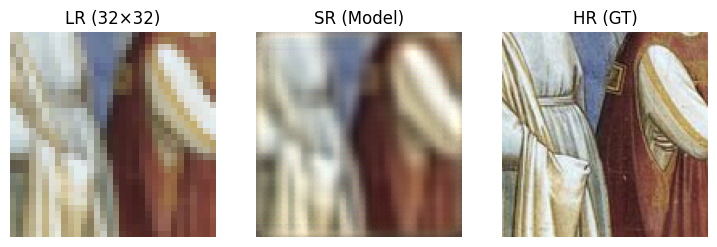

In [ ]:
import matplotlib.pyplot as plt
import cv2

model.eval()
with torch.no_grad():
    lr, hr = test_dataset[1]
    lr = lr.unsqueeze(0).to(device)
    sr = model(lr).cpu().squeeze(0)

# Convert CHW → HWC
lr = lr.cpu().squeeze(0).permute(1, 2, 0)
sr = sr.permute(1, 2, 0)
hr = hr.permute(1, 2, 0)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.title("LR (32×32)")
plt.imshow(lr)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("SR (Model)")
plt.imshow(sr)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("HR (GT)")
plt.imshow(hr)
plt.axis("off")

plt.show()


### Enhanced Model with Residual Connections

The improved model, incorporating residual connections and perceptual loss, demonstrates marginally enhanced PSNR values. While the numerical improvement is modest due to the constrained resolution of high-resolution images (128×128 pixels), the generated super-resolution images exhibit substantially sharper features and improved detail preservation.

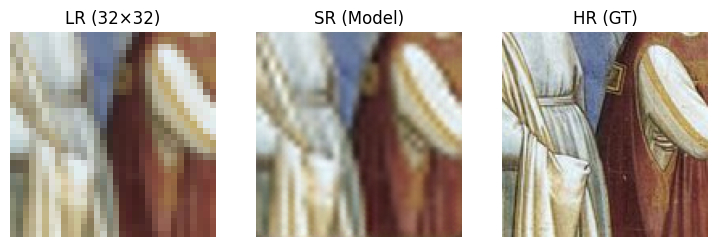

In [ ]:
import matplotlib.pyplot as plt
import cv2

model.eval()
with torch.no_grad():
    lr, hr = test_dataset[1]
    lr = lr.unsqueeze(0).to(device)
    sr = model(lr).cpu().squeeze(0)

# Convert CHW → HWC
lr = lr.cpu().squeeze(0).permute(1, 2, 0)
sr = sr.permute(1, 2, 0)
hr = hr.permute(1, 2, 0)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.title("LR (32×32)")
plt.imshow(lr)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("SR (Model)")
plt.imshow(sr)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("HR (GT)")
plt.imshow(hr)
plt.axis("off")

plt.show()


### Conclusions

The super-resolution images generated by the enhanced model demonstrate notably superior visual fidelity compared to the baseline approach. The model's performance is fundamentally constrained by the limited resolution of the input low-resolution images (32×32 pixels), which restricts the amount of recoverable high-frequency information.